# INSIGHT DATA SCIENCE FELLOWS

**The INSIGHT Data Science Fellows Program** is very competitive fellowship targeted at academics from the top universities. It helps recent PhDs and Postdocs to find a prestigious job as data scientists in the industry. 


I was really curious about **who are these top 'quants'**. So I scraped the data from the INSIGHT website and did some quick EDA. Here's my script:

In [1]:
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import json

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats

from wordcloud import WordCloud, STOPWORDS
from collections import Counter

%matplotlib inline

# PART 1.1: Scraping Data

In [2]:
project = []
company = []
position = []
background = []
name = []

In [3]:
url = 'https://www.insightdatascience.com/fellows?61ea5d1b_page=%s'
for idx in range(1, 9):
    print(f'fill scrap - {url % idx}')
    result = requests.get(url % idx)
    content = result.content
    
    soup = BeautifulSoup(content)
    project_per_page = [x.get_text() for x in soup.find_all("div", "tooltip_project")]
    project.extend(project_per_page)
    company.extend([x.get_text() for x in soup.find_all("div", "tooltip_company")])
    position.extend([x.get_text() for x in soup.find_all("div", "toottip_title")])
    name.extend([x.get_text() for x in soup.find_all("div", "tooltip_name")])
    background.extend([x.get_text() for x in soup.find_all("div", "tooltip_background")])
    
    print(result.status_code)
    print(project_per_page[0])

fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=1
200
Measuring the Impact of Open Source Coders on Github
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=2
200
StreetsAhead: Image recognition with deep learning in Street View
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=3
200
ATHOS gear: Logging your workout with wearable EMG techology
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=4
200
GoodReviews: Deliver the most useful positive and negative book reviews
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=5
200
DealWheels: Used Cars Online-Great deal?
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=6
200
L' Tron - CTA: A Friendly Bot with an Eye on Chicago's 'L'
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=7
200
Fleetr
fill scrap - https://www.insightdatascience.com/fellows?61ea5d1b_page=8
200
SignWrite: Transcribing sign lang

In [4]:
# create tuples out of 4 features
zipped = np.array(list(zip(name, company, project, position, background)))

In [5]:
insight = pd.DataFrame(np.array(zipped), columns=['name', 'company', 'project', 'position', 'background'])

In [6]:
insight.head()

,name,company,project,position,background
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on ...,Director of Risk,"Bio-X Games, Stanford, Postdoc"
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University, PhD\n"
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Data Scientist,"Operations Research, MIT, PhD"
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc"
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc"


In [7]:
insight.shape

(794, 5)

# PART 1.2: CLEANING

Some company names were parsed incorrectly. I created json file with correct codes:

In [8]:
with open('assets/company_codes_correct.json', 'r+') as file:
    company_codes = json.load(file)

In [9]:
insight['company'] = insight['company'].replace(company_codes)

Adding the new features 'University', 'Field', 'Postdoc' extracted from Background:

In [12]:
insight.background[insight['background'].str.contains('Astrophysics/Cosmology')]

48    Astrophysics/Cosmology,,Carnegie Mellon Univer...
Name: background, dtype: object

In [13]:
insight_clean = insight.iloc[:, :]
insight_clean['status'] = 0
insight_clean['university'] = 0
insight_clean['field'] = 0

for i in range(insight['background'].shape[0]):
    
    #correcting all Postdoct
    if insight_clean['background'].iloc[i][-8:] == 'Postdoct':
        insight_clean['background'].iloc[i] = insight_clean['background'].iloc[i][:-1]

    if 'Ph.D.' in insight['background'].iloc[i]:
        #print(insight['background'].iloc[i])
        insight['background'].iloc[i] = insight['background'].iloc[i].replace('Ph.D.', 'PhD')
    
    if 'DPhil' in insight['background'].iloc[i]:
        #print(insight['background'].iloc[i])
        insight['background'].iloc[i] = insight['background'].iloc[i].replace('DPhil', 'PhD')
    
    if insight['background'].iloc[i][-4:] == ' PhD':
        insight['background'].iloc[i] = insight['background'].iloc[i].replace(' PhD', ', PhD')
    
    if insight['background'].iloc[i][-8:] == ' Postdoc':
        insight['background'].iloc[i] = insight['background'].iloc[i].replace(' Postdoc', ', Postdoc')
        
    # trailing ',' at the beginning of background 
    if insight_clean['background'].iloc[i][0] == ',':
        #print(insight_clean['background'].iloc[i])
        insight_clean['background'].iloc[i] = insight_clean['background'].iloc[i][1:]

     # trailing ',' at the end of background     
    if insight_clean['background'].iloc[i][-1] == ',':
        #print(insight_clean['background'].iloc[i])
        insight_clean['background'].iloc[i] = insight_clean['background'].iloc[i][:-1]
    
    #replacing badly parsed tags
    insight_clean['background'].iloc[i] = insight['background'].iloc[i].replace(',,', ',').replace('\n', ',')
    insight_clean['background'].iloc[i] = insight['background'].iloc[i].replace('\xa0', ',').replace('<br>', ',')

    if ".University" in insight['background'].iloc[i]:
        insight['background'].iloc[i] = insight['background'].iloc[i].replace(".", ",")
    
    #splitting by ','
    bckgr2 = [x.strip() for x in insight['background'].iloc[i].split(',')]

    if bckgr2[-1] in ['Postdoc', 'PhD']:
        insight_clean['status'].iloc[i] = bckgr2[-1]       
    else:
        #for those that are neither Postdoc, nor Phd (working professionals, PhD Candidate, ABD, B.Math as 'Other'
        insight_clean['status'].iloc[i] = 'Other'
    
    # !add no uni and field for those with Other status
    if insight_clean['status'].iloc[i] == 'Other':
        insight_clean['university'].iloc[i] = ''
        insight_clean['field'].iloc[i] = ''
    
    #the correct split pattern should produce 3 features - field, university, status. Checking for <3 and >3 as well
    if len(bckgr2) < 3:            
        if all(u_s in bckgr2[-1] for u_s in ['University', 'PhD']):
            insight_clean['status'].iloc[i] = 'PhD'
            insight_clean['university'].iloc[i] = bckgr2[-1][0:-3].strip()
        if all(u_s in bckgr2[-1] for u_s in ['University', 'Postdoc']):
            insight_clean['status'].iloc[i] = 'Postdoc'
            insight_clean['university'].iloc[i] = bckgr2[-1][0:-7].strip()
    
    elif (len(bckgr2) == 3):
        if (insight_clean['status'].iloc[i] != 'Other'):
            insight_clean['university'].iloc[i] = bckgr2[-2]
            insight_clean['field'].iloc[i] = bckgr2[0]
                  
    elif len(bckgr2) > 3:
        if bckgr2[-3] in ["University of California", "University of Illinois", "University of Texas",
                          "University of Maryland", "University of Colorado"]:
            insight_clean['university'].iloc[i] = " - ".join(bckgr2[-3:-1])
            insight_clean['field'].iloc[i] = bckgr2[0]
        elif any(univ in bckgr2[-3] for univ in ['Institute', 'Istitut', 'University', 'Academia']):
            insight_clean['university'].iloc[i] = " - ".join(bckgr2[-3:-1])
            insight_clean['field'].iloc[i] = bckgr2[0]
        elif any(univ in bckgr2[-4] for univ in ['Institute', 'Istitut', 'University', 'Academia']):
            #print(bckgr2)
            insight_clean['university'].iloc[i] = " - ".join(bckgr2[-4:-1])
            insight_clean['field'].iloc[i] = bckgr2[0]
        elif any(f in bckgr2[1].lower() for f in ['chemistry', 'physics', 'neural', 'engineering', 'medical']):
            #print(bckgr2)
            insight_clean['field'].iloc[i] = " ".join(bckgr2[:2])
            insight_clean['university'].iloc[i] = bckgr2[-2]
        elif (insight_clean['status'].iloc[i] != 'Other'):
            #check with print(bckgr2) if the rest bckgr2 can be attributed to university 
            print(bckgr2)
            insight_clean['university'].iloc[i] = " - ".join(bckgr2[-3:-1])    
            insight_clean['field'].iloc[i] = bckgr2[0]

['Behavioral Economics', 'ECARES', 'ULB', 'Postdoc']
['Biomedical Engineering', 'Georgia Tech', 'Emory University', 'PhD']


In [14]:
insight_clean.head()

,name,company,project,position,background,status,university,field
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on ...,Director of Risk,"Bio-X Games, Stanford, Postdoc",Postdoc,Stanford,Bio-X Games
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University,PhD",PhD,Harvard University,Physics
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Data Scientist,"Operations Research, MIT, PhD",PhD,MIT,Operations Research
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc",Postdoc,Stanford,Statistics
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc",Postdoc,Stanford,Mathematics


Checking if we attributed all values correctly:

In [15]:
#manual attribution for individual cases if they are Postdoc or PhD
print(insight_clean.loc[266, 'background'])
insight_clean.loc[266, 'university'] = 'Harvard'
insight_clean.loc[266, 'field'] = 'Astrophysics'

print(insight_clean.loc[363, 'background'])
insight_clean.loc[363, 'university'] = ''
insight_clean.loc[363, 'field'] = 'Astronomy'

print(insight_clean.loc[765, 'background'])
insight_clean.loc[765, 'background'] = insight_clean.loc[765, 'project']
insight_clean.loc[765, 'project'] = 'ArtPricer: Sell it already!'
insight_clean.loc[765, 'university'] = 'Stanford University'
insight_clean.loc[765, 'field'] = 'Evolutionary Biology'
insight_clean.loc[765, 'status'] = 'Postdoc' 

print(insight_clean.loc[525, 'background'])
insight_clean.loc[525, 'university'] = 'University of Minnesota'
insight_clean.loc[525, 'field'] = 'Astrophysics'

print(insight_clean.loc[699, 'background'])
insight_clean.loc[699, 'university'] = 'Cornell University'
insight_clean.loc[699, 'field'] = ''

Harvard-Smithsonian Center for Astrophysics, Postdoc
Observational Astronomy, PhD
ArtPricer: Sell it already!
Astrophysics,University of Minnesota, Postdoc
Cornell University, PhD


In [16]:
#checking if we have attributed all values and there are no data with 0s
assert len(insight_clean[insight_clean['status'] == 0]) == 0, "Oops! We have few values with 0s left!"
assert len(insight_clean[insight_clean['university'] == 0]) == 0, "Oops! We have few values with 0s left in university column!"
assert len(insight_clean[insight_clean['field'] == 0]) == 0, "Oops! We have few values with 0s left in field column!"
print("all tests passed!")

all tests passed!


Some uni names were parsed incorrectly. I created json file with correct codes:

In [17]:
with open('assets/university_codes_correct.json', 'r+') as file:
    uni_codes = json.load(file)

In [18]:
insight['university'] = insight['university'].replace(uni_codes)

In [19]:
insight.head()

,name,company,project,position,background,status,university,field
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on ...,Director of Risk,"Bio-X Games, Stanford, Postdoc",Postdoc,Stanford,Bio-X Games
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University,PhD",PhD,Harvard,Physics
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Data Scientist,"Operations Research, MIT, PhD",PhD,MIT,Operations Research
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc",Postdoc,Stanford,Statistics
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc",Postdoc,Stanford,Mathematics


In [20]:
insight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 794 entries, 0 to 793
Data columns (total 8 columns):
name          794 non-null object
company       794 non-null object
project       794 non-null object
position      794 non-null object
background    794 non-null object
status        794 non-null object
university    794 non-null object
field         794 non-null object
dtypes: object(8)
memory usage: 49.8+ KB


Commentary: We have 1 NaN in 'Company', 3 NaNs in 'Position'. Missing values in 'University' and 'Field' columns are due to not encoding this info for those with'Other'status (working professionals).

In [21]:
# Saving scraped dataset to csv file:
insight.to_csv(path_or_buf='data/insight_dataset_cleaned.csv', sep=';', index=False)

## Summary: 

The final dataset has 794 observations (i.e. so many fellows participated in the INSIGHT Data Science Fellowship as of 04/21/2019) and 5 features:
1. Name
2. Company
3. Project
4. Position
5. Background 
6. University
7. (Academic) Field

All working/studying professionals that are not PhD or Postdoc were coded as 'Other' and do not contain information on University or Field.

# PART 2: ANALYSIS

In [22]:
insight = pd.read_csv('data/insight_dataset_cleaned.csv', sep=';')

In [23]:
insight.shape

(794, 8)

In [24]:
insight.head()

,name,company,project,position,background,status,university,field
0,JP Bida,Capital One,Measuring the Impact of Open Source Coders on ...,Director of Risk,"Bio-X Games, Stanford, Postdoc",Postdoc,Stanford,Bio-X Games
1,Douglas Mason,Twitter,Email Searcher: Search & Visualize Your Mailbox,Data Scientist,"Physics, Harvard University,PhD",PhD,Harvard,Physics
2,Virot Ta Chiraphadhanakul,Facebook,Tweet Timeline: Visualizing the Impact of Soci...,Data Scientist,"Operations Research, MIT, PhD",PhD,MIT,Operations Research
3,Julia Viladomat,Adobe,Sentiment Analysis Based on Social Media,Data Scientist,"Statistics, Stanford, Postdoc",Postdoc,Stanford,Statistics
4,David Freeman,LinkedIn,Flight Delay Predictor,Head of Anti-Abuse Engineering,"Mathematics, Stanford, Postdoc",Postdoc,Stanford,Mathematics


## 2.1. COMPANIES:

In [25]:
#how many companies?
companies = insight['company'].unique()
len(companies)

383

In [26]:
def grouped_by_companies():
    '''
    Returns Data Frame with number of fellows grouped by companies
    '''
    company_num = [insight['company'][insight['company'] == companies[i]].count() for i in range(len(companies))]
    companies_grouped = pd.DataFrame({'company': companies, 'company_num': company_num})
    companies_grouped = companies_grouped.sort_values(by='company_num', ascending=False).reset_index(drop=True)

    return companies_grouped

In [27]:
companies_grouped = grouped_by_companies()
companies_grouped.head(10)

,company,company_num
0,Facebook,54
1,LinkedIn,22
2,Stitch Fix,19
3,Netflix,15
4,Intuit,14
5,Insight Data Science,13
6,Yelp,12
7,Gartner,12
8,Uber,12
9,Schireson,11


In [28]:
print("{} fellows work in top30 companies which is {:.2f}%".format(companies_grouped.head(30).company_num.sum(), 100*companies_grouped.head(30).company_num.sum()/insight.shape[0]))

322 fellows work in top30 companies which is 40.55%


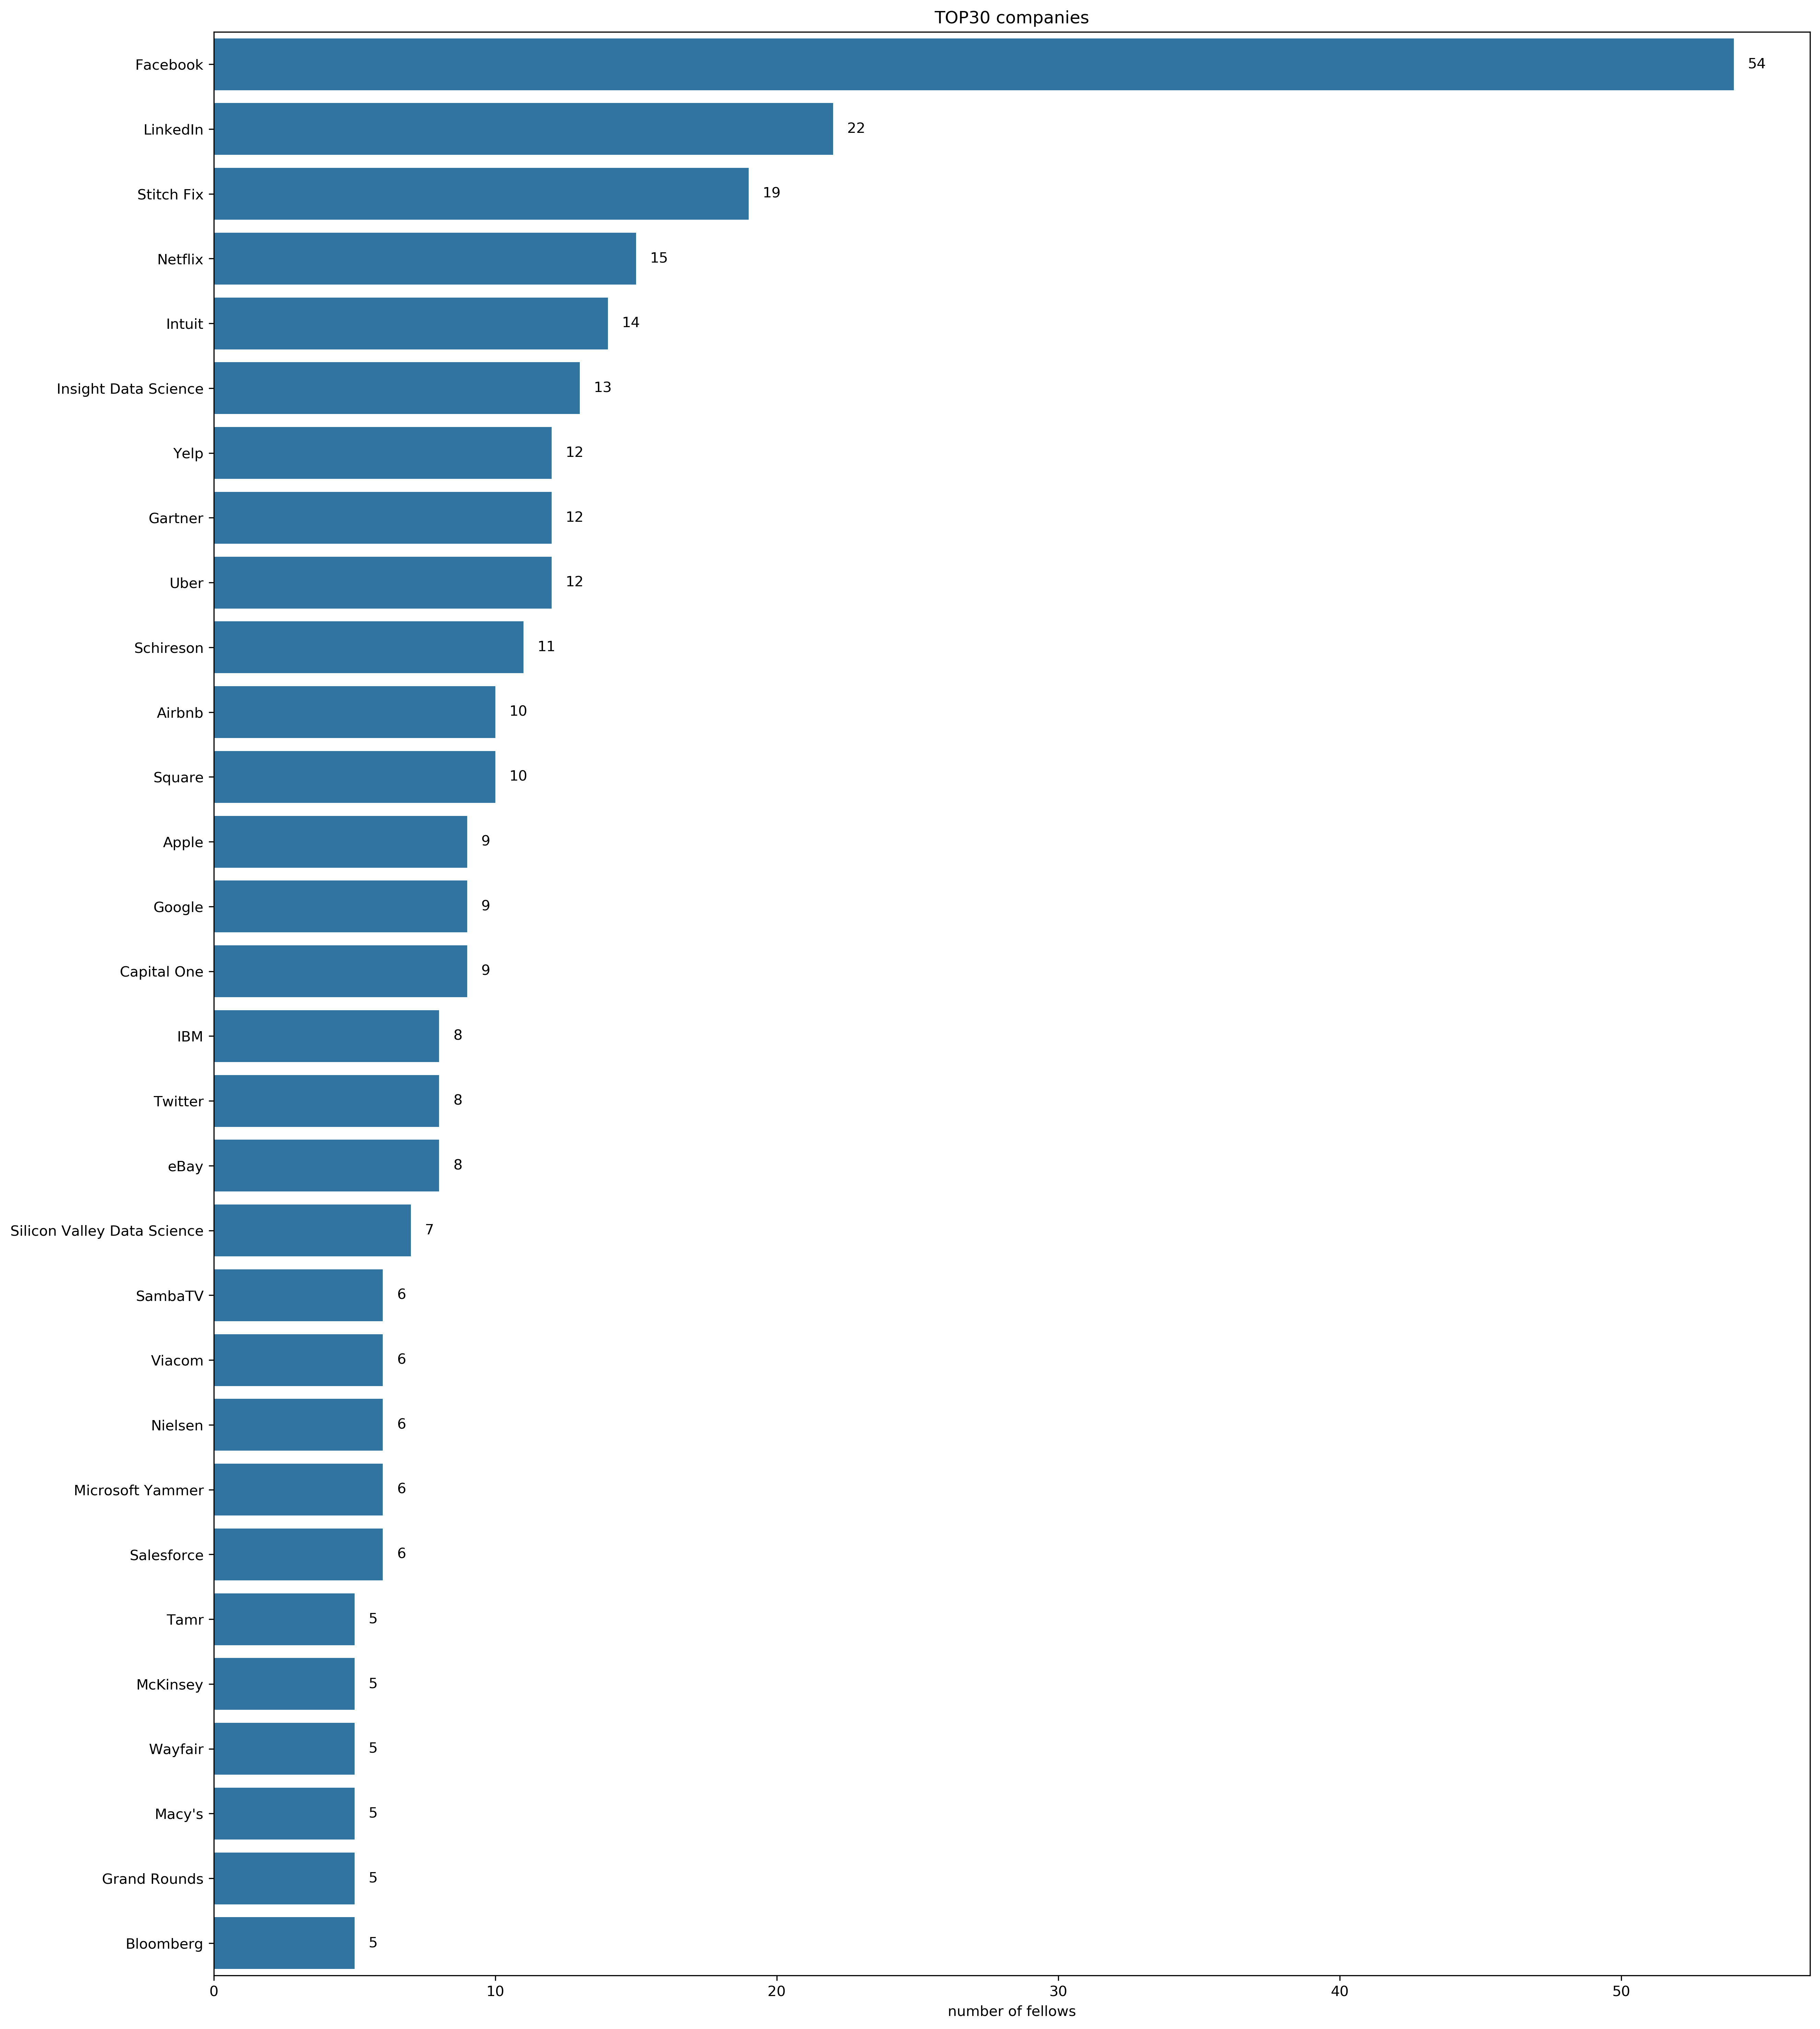

In [29]:
base_color = sns.color_palette()[0]

plt.figure(figsize=(20,25), dpi=300)
sns.barplot(y = companies_grouped.company[:30], x = companies_grouped.company_num[:30], color=base_color);
plt.title("TOP30 companies")
plt.xlabel("number of fellows")
plt.ylabel("")
for i in range(30):
    #X position just after the end of the bar:
    count = companies_grouped['company_num'][i]
    plt.text(count+0.5, i, count, va = 'center');

In [30]:
print("{} companies hired just 1 fellow which is {:.2f}% of all companies".format(
    companies_grouped.company_num[companies_grouped.company_num == 1].count(),
    100*companies_grouped.company_num[companies_grouped.company_num == 1].count()/len(companies)))

275 companies hired just 1 fellow which is 71.80% of all companies


## Summary:
There are 383 companies where INSIGHT fellows started working. However, there are no strong patterns where fellows find jobs, since 71% of companies hired just 1 fellow. <br>

Still, 23.17% of all fellows work in the top10 companies. <br>

The top 5 companies that hire actively data scientists are Facebook (54 fellows), LinkedIn (22), Stich Fix (19), Netflix (15) and Intuit (14). All five are in the Silicon Valley, where the demand for Data Scientist is naturally the highest.



## 2.2. UNIVERSITIES:

In [31]:
uni_unique = insight['university'].unique()
print("fellows come from {} different universities".format(len(uni_unique)))

fellows come from 199 different universities


In [32]:
def grouped_by_unis():
    '''
    Returns Data Frame with number of fellows grouped by universities
    '''
    uni_num = [insight['university'][insight['university'] == uni_unique[i]].count() for i in range(len(uni_unique))]
    uni_grouped = pd.DataFrame({'university': uni_unique, 'university_num': uni_num})
    uni_grouped = uni_grouped.sort_values(by='university_num', ascending=False).reset_index(drop=True)
    
    return uni_grouped

In [33]:
uni_grouped = grouped_by_unis()

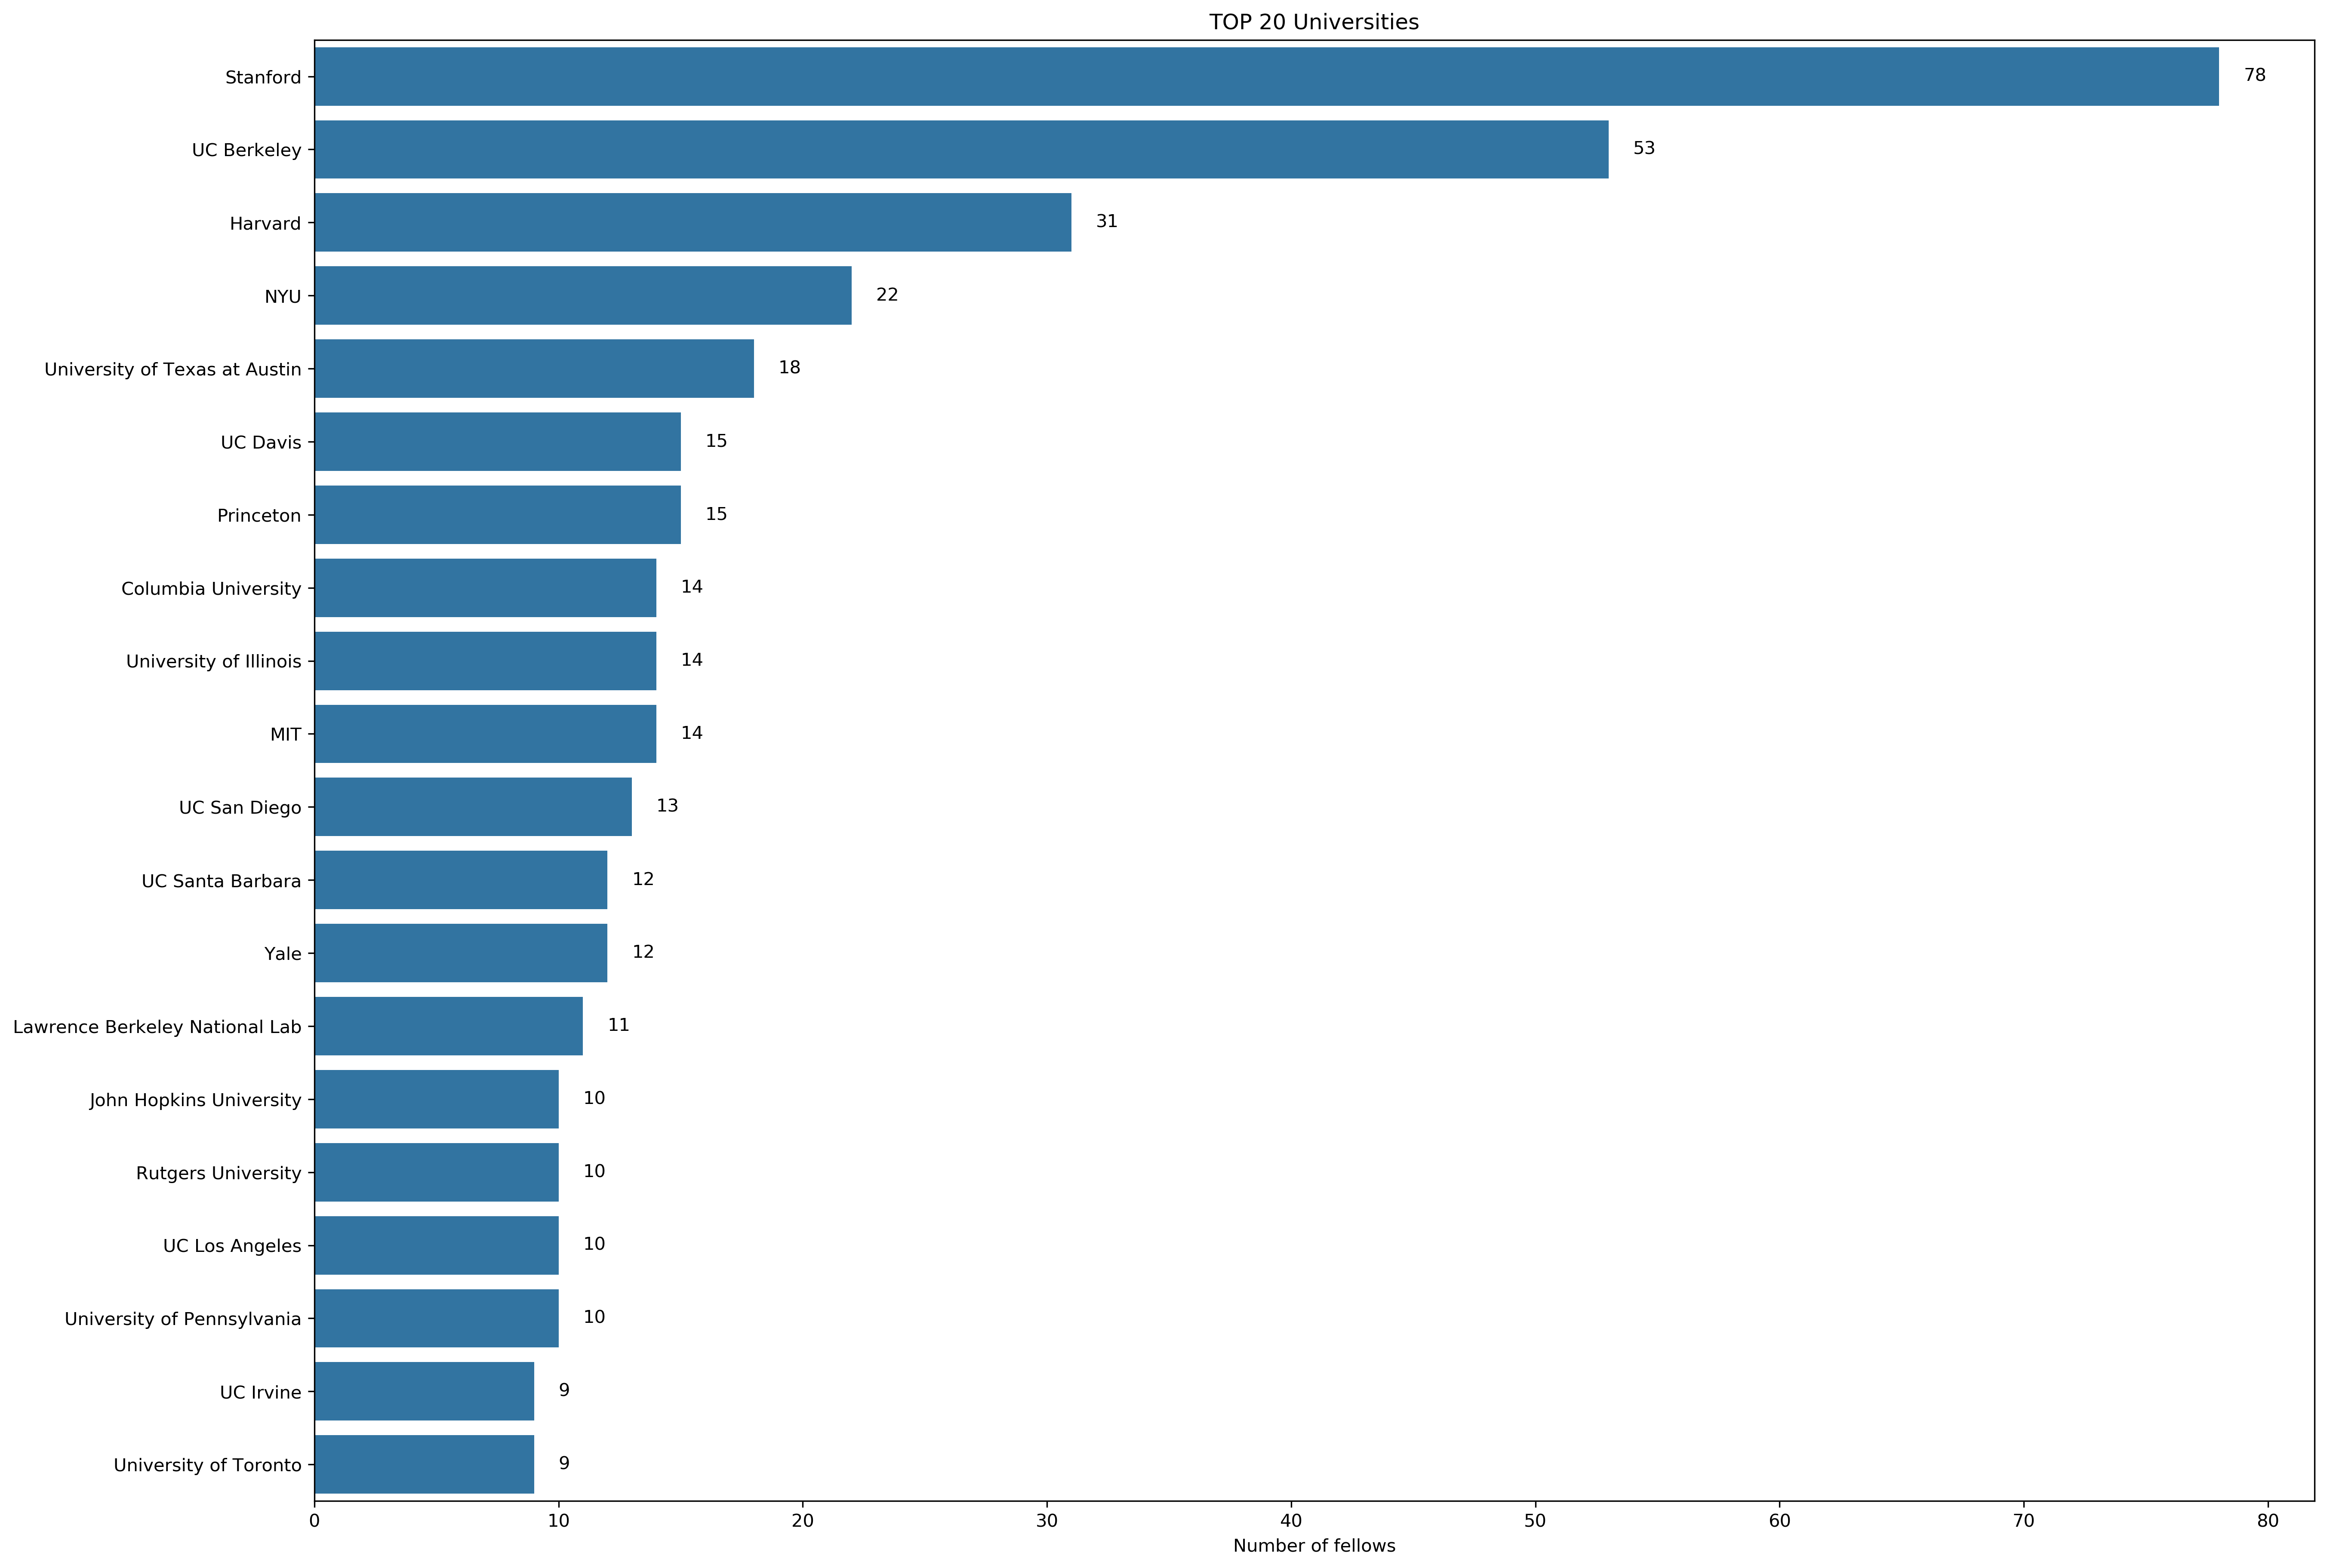

In [34]:
plt.figure(figsize=(20,15), dpi=300)
sns.barplot(y = uni_grouped.university[:20], x = uni_grouped.university_num[:20], color=base_color);
plt.title('TOP 20 Universities');
plt.xlabel('Number of fellows')
plt.ylabel("")
for i in range(20):
    #X position just after the end of the bar:
    count = uni_grouped['university_num'][i]
    plt.text(count+1, i, count, va = 'center');

In [35]:
mask_cal_unis = uni_grouped.university.str.contains('Stanford|UC') & ~uni_grouped.university.isna()
print(f"{uni_grouped[mask_cal_unis].university_num.sum()} fellows come from Californian universities, which is equivalent to {uni_grouped[mask_cal_unis].university_num.sum()/insight.shape[0]*100:.2f}%")
uni_grouped[mask_cal_unis]

219 fellows come from Californian universities, which is equivalent to 27.58%


,university,university_num
0,Stanford,78
1,UC Berkeley,53
5,UC Davis,15
10,UC San Diego,13
11,UC Santa Barbara,12
16,UC Los Angeles,10
18,UC Irvine,9
21,UC Santa Cruz,9
30,UC Riverside,6
35,UCSF,5


In [36]:
print("top20 universities account for {} fellows which is {:.2f}%".format(uni_grouped.head(20).university_num.sum(), 
                                                                          100*uni_grouped.head(20).university_num.sum()/insight.shape[0]))

top20 universities account for 380 fellows which is 47.86%


## Summary:

The 794 INSIGHT Fellows come from 198 different universities - very diverse!  <BR> 
    
However, 35% of all fellows come from just TOP10 universities. Moreover, almost 30% of fellows (219) are from the three Californian universities - Stanford or other UCs. The pattern is not suprising given the insight from the previous step - namely that it is primarily Silicon Valley companies that hire DS fellows the most. <br>
    
The top 5 universities that convert PhDs to data scientists are Stanford (79 fellows), UC Berkeley (53), Harvard (31), NYU (22) and MIT (14).

## 2.3. ACADEMIC FIELD:

In [37]:
def grouped_by_field():
    '''
    Returns Data Frame with aggregated by field values and their counts
    '''
    fields = ['Physics', 'Chemistry', 'Biology', 'Statistics', 'Mathematic', 'Mechanical Engineering',
              'Astrophysics', 'Neuroscience', 'Genetics', 'Biophysics', 'Biochemistry','Psychology', 'Ecology', 'Politic',
             'Linguistics', 'Computer Science', 'Environment','Astronomy', 'Biomedical Engineering', 'Bioinformatics',
             'Electrical Engineering', 'Biostatistics']
    fields_num = []
    nonans = insight[~insight['field'].isna()]
    
    for each in fields:
        fields_nb = nonans['field'][nonans['field'].str.contains(each)].count()
        fields_num.append(fields_nb)
    result = list(zip(fields, fields_num))
    fields = pd.DataFrame(data=result, columns=['fields', 'fields_num'])
    fields = fields.sort_values(by='fields_num', ascending=False).reset_index(drop=True)
    fields['fields_pct'] = round(100*fields['fields_num']/insight.shape[0], 2)
    
    return fields

In [38]:
fields = grouped_by_field()

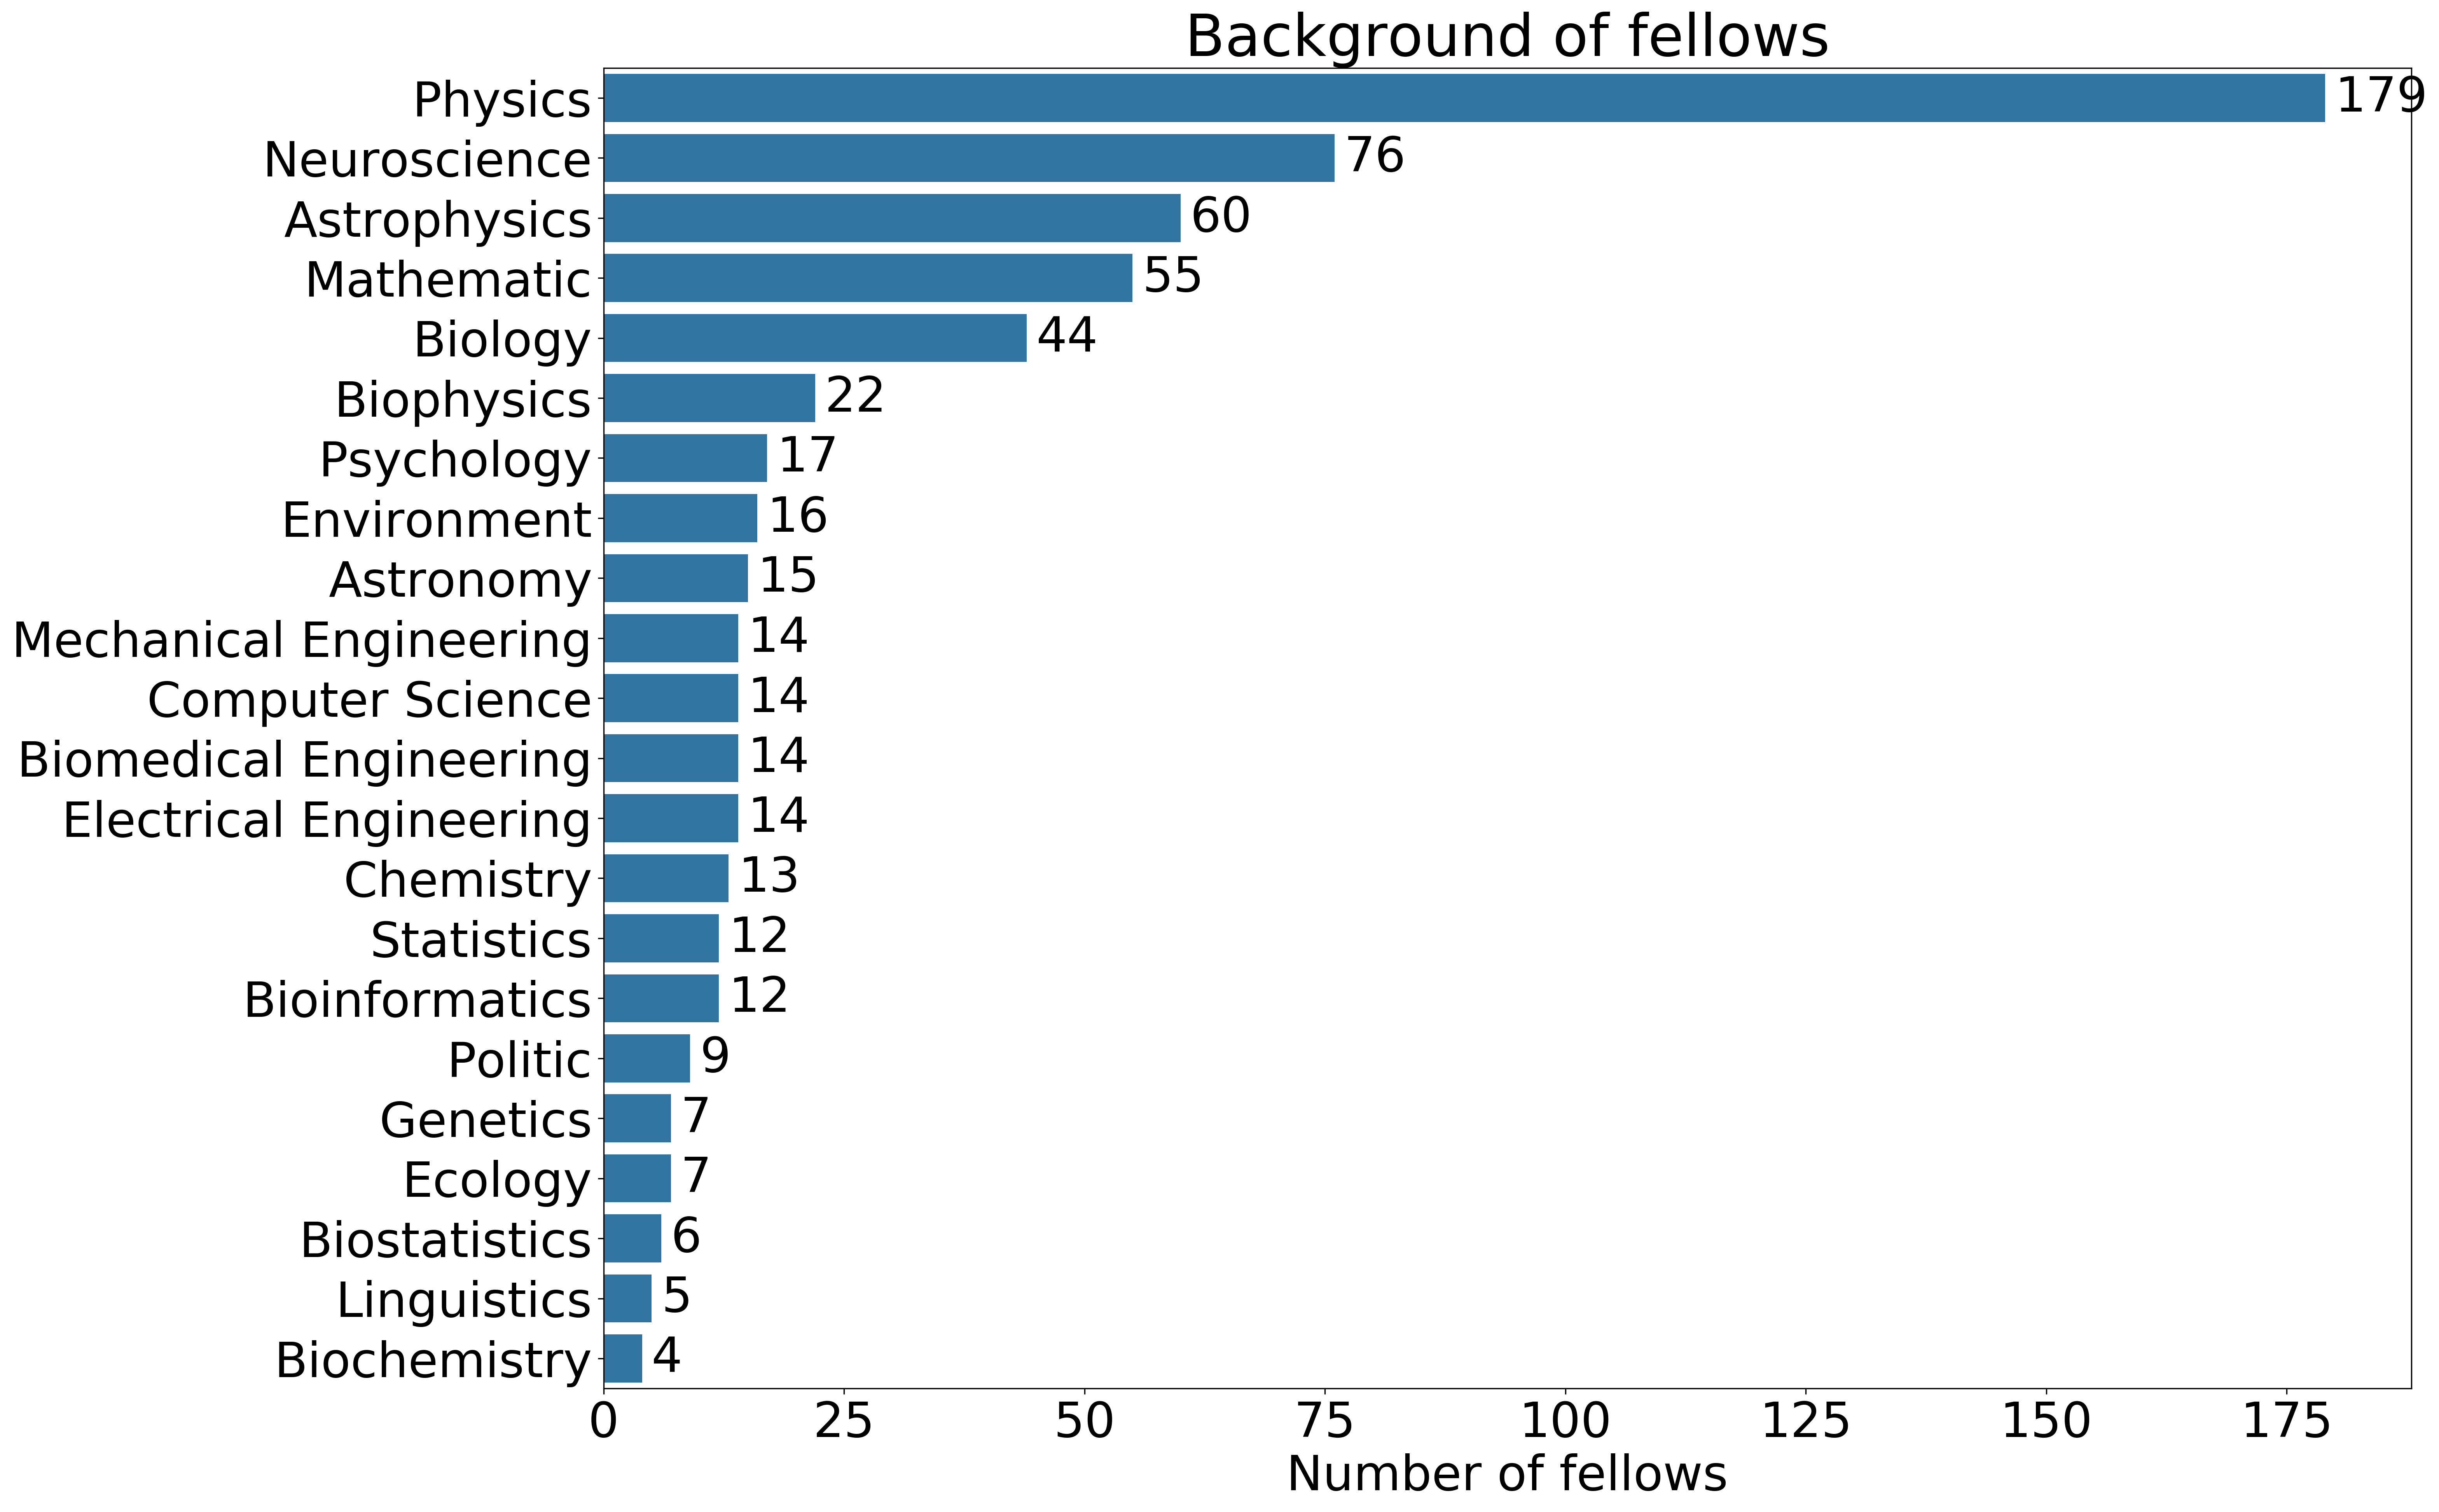

In [39]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,15), dpi=300)
sns.barplot(y = fields.fields, x = fields.fields_num, color=base_color);
plt.title('Background of fellows');
plt.xlabel('Number of fellows')
plt.ylabel("")
for i in range(len(fields.fields_num)):
    #X position just after the end of the bar:
    count = fields['fields_num'][i]
    plt.text(count+1, i, count, va = 'center');

In [40]:
# % of all insight fellows covered by above fields 
round(100*fields.fields_num.sum()/insight.shape[0], 2)

77.46

### Fellows from Political Science (like me :) 

In [41]:
insight[insight['background'].str.contains('Polit')]

,name,company,project,position,background,status,university,field
140,Alex Ruiz-Euler,Viacom,Yelper Helper: An engine for tailored Yelp Rev...,"Senior Data Scientist, Audience Science","Political Economy, UCSD, PhD",PhD,UC San Diego,Political Economy
147,Marco Morales,NBC,Ticket Me If You Can: Fending off parking tick...,"Associate Director, Management Science & Integ...","Political Science, New York University, PhD",PhD,NYU,Political Science
172,Lindsay Pettingill,Airbnb,dr-findr: A web app that helps you find the do...,Data Scientist,"Political Science, Georgetown University, PhD",PhD,Georgetown University,Political Science
280,Gabriel Michael,Schireson,Can I Solar?: Helping you decide if solar powe...,Data Scientist,"Political Science, Yale, Postdoc",Postdoc,Yale,Political Science
612,Marlene Guraieb,Oscar,Write right! Helping CrossLead identify succes...,Data Scientist,"Political Science, New York University, PhD",PhD,NYU,Political Science
641,Kelly Zhang,Social Capital,Opinionated,Data Scientist,"Political Science, Stanford University, PhD",PhD,Stanford,Political Science
658,Nhung Bui,Google,Travel Smart,Data Scientist,"Politics, Princeton University, PhD",PhD,Princeton,Politics
675,Michael Dougal,Netflix,Hatched News,Sr. Research Scientist,"Political Science, UC Berkeley, PhD",PhD,UC Berkeley,Political Science
708,Matthew Barnes,84.51,Pay It Forward: Predicting Who Will Miss a Stu...,Senior Analyst,"Political Science, Princeton University, PhD",PhD,Princeton,Political Science


## Summary:

Almost every third comes from Physics/Astrophysics (32%). The next biggest group - 10% - are neuroscientists. <br>
Among 794 fellows, only 9 have graduated degree in political science!



## 2.4. PhD vs Postdoc

In [42]:
#how many PhDs?
print('{} fellows are fresh PhDs...'.format(insight.status[insight['status'] =='PhD'].count()))

506 fellows are fresh PhDs...


In [43]:
#how many postdocs?
print('...compared to {} fellows that are Postdocs'.format(insight.status[insight['status'] =='Postdoc'].count()))

...compared to 229 fellows that are Postdocs


In [44]:
# distribution
print('so distribution is as follows: {:.1f}% postdocs and {:.1f}% PhDs'.format(
    100*insight.status[insight['status'] =='Postdoc'].count()/insight.shape[0],
    100*insight.status[insight['status'] =='PhD'].count()/insight.shape[0]))

so distribution is as follows: 28.8% postdocs and 63.7% PhDs


In [45]:
print('there are also {} practitioners or {:.1f}%'.format(insight.status[insight['status'] =='Other'].count(),100*insight.status[insight['status'] =='Other'].count()/insight.shape[0]))

there are also 59 practitioners or 7.4%


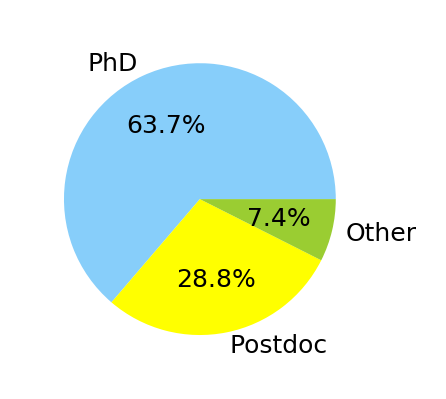

In [46]:
plt.rcParams.update({'font.size': 6})
plt.figure(figsize=(5,1.5), dpi=300)
labels = 'PhD', 'Postdoc', 'Other'
sizes = [506, 229, 59]
colors = ['lightskyblue', 'yellow', 'yellowgreen']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%');

## Summary:

The majority of fellows are freshly completed PhDs - 64%. There are about 29% postdocs among the INSIGHT fellows. But there is also a small amount of practitioners (uni faculty, manager, researchers). <br>

## Top10 companies

In [47]:
top10_companies = insight.company[insight['company'].isin(companies_grouped.company.head(10))]
pd.crosstab(top10_companies, insight.status, margins=True).T

company,Facebook,Gartner,Insight Data Science,Intuit,LinkedIn,Netflix,Schireson,Stitch Fix,Uber,Yelp,All
status,,,,,,,,,,,
Other,5,1,0,0,1,1,2,1,1,0,12
PhD,31,7,9,11,11,10,5,13,9,8,114
Postdoc,18,4,4,3,10,4,4,5,2,4,58
All,54,12,13,14,22,15,11,19,12,12,184


Interestingly, LinkedIn stands out from the rest 9 companies in that it hired disproportionally more postdocs compared to other top10 companies. Let's check the hypothesis.<br>

## Hypothesis Testing via Bootstrapping

### 1.  Do top10 companies hire on average more Postdocs than other companies do?

First, let's check the hypothesis whether top10 companies prefer to hire Postdocs. We will do it via bootstrapping. Our "treatment" in this case is "top10 companies". So we divide our initial dataset into two groups - "top10" and "not top10" and compare the postdoc means for both groups. Then we bootstrap (resample with replacement) the data 10000 times and check if the difference between postdoc means for top10 group and not_top10 group is statistically significant. 

**H<sub>0</sub>**: top10 postdoc mean <= non_top10 postdoc mean <br>
**H<sub>1</sub>**: top10 postdoc mean > non_top10 postdoc mean

In [48]:
set(top10_companies)

{'Facebook',
 'Gartner',
 'Insight Data Science',
 'Intuit',
 'LinkedIn',
 'Netflix',
 'Schireson',
 'Stitch Fix',
 'Uber',
 'Yelp'}

In [49]:
#recode postdoc column to calc mean more quickly - 1 if postdoc
insight['postdoc_recoded'] = insight.status.apply(lambda x: 1 if x == "Postdoc" else 0)

In [50]:
top10_insight = insight[insight.company.apply(lambda x: x in set(top10_companies)) == True]
top10_insight.shape

(184, 9)

In [51]:
#insight fellows not from top10_companies
not_top10_insight = insight[insight.company.apply(lambda x: x not in set(top10_companies)) == True]
not_top10_insight.shape

(610, 9)

In [52]:
top10_postdoc_mean = top10_insight.postdoc_recoded.mean()
top10_postdoc_mean

0.31521739130434784

In [53]:
not_top10_postdoc_mean = not_top10_insight.postdoc_recoded.mean()
not_top10_postdoc_mean

0.28032786885245903

In [54]:
obs_diff = top10_postdoc_mean - not_top10_postdoc_mean
obs_diff

0.03488952245188881

In [55]:
#create sampling distribution for difference in postdoc means with bootstrapping
def sampling_dist_bootstrap():
    '''
    Returns difference in postdoc means in sampling distribution generated via bootstrapping
    '''
    diffs = []
    for _ in range(10000):
        b_sample = insight.sample(insight.shape[0], replace=True)
        top10_insight = b_sample[b_sample.company.apply(lambda x: x in set(top10_companies)) == True]
        top10_postdoc_mean = top10_insight.postdoc_recoded.mean()
        not_top10_insight = b_sample[b_sample.company.apply(lambda x: x not in set(top10_companies)) == True]
        not_top10_postdoc_mean = not_top10_insight.postdoc_recoded.mean()
        diffs.append(top10_postdoc_mean - not_top10_postdoc_mean)
    return diffs

In [56]:
diffs = sampling_dist_bootstrap()

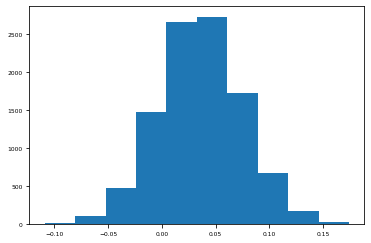

In [57]:
# convert to numpy array
diffs = np.array(diffs)
# plot distribution
plt.hist(diffs);

In [58]:
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

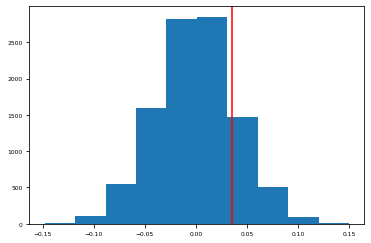

In [59]:
# plot null distribution
plt.hist(null_vals);

# plot line for observed statistic
plt.axvline(x=obs_diff, color = 'red');

In [60]:
# compute p value
(null_vals > obs_diff).mean()

0.1789

## Conclusion:
With a type I error rate of 0.05, we don't have evidence that the top10 companies prefer hiring postdocs over PhDs (p-value=0.1789). We have to retain H<sub>0</sub> hypothesis.

Let's check our calculations with analytic approach by doing one-tailed z-test:

## Analytic Approach

In [61]:
# get number of trials and overall 'success' rate under null
n_top10 = top10_insight.shape[0]
n_non_top10 = not_top10_insight.shape[0]
p_null = insight['postdoc_recoded'].mean()
print("number of trials: top10 - {}, non_top10 - {}".format(n_top10, n_non_top10))
print('success rate under null: ', p_null)

number of trials: top10 - 184, non_top10 - 610
success rate under null:  0.2884130982367758


In [62]:
# compute standard error, z-score, and p-value
se_p = np.sqrt(p_null * (1-p_null) * (1/n_top10 + 1/n_non_top10))
print("standard error", se_p)
print("observed difference", top10_postdoc_mean - not_top10_postdoc_mean)

z = (top10_postdoc_mean - not_top10_postdoc_mean) / se_p
print("z-value", z)
print("p-value", 1-stats.norm.cdf(z))

standard error 0.038102887182154405
observed difference 0.03488952245188881
z-value 0.9156661091086404
p-value 0.17992102289711975


## Conclusion: 
we got the same p-value of about 0.179 with both bootstraping and analytic approaches. We conclude that top10 companies, when hiring Insight fellows, have no preferences with regard to PhDs or Postdocs.

### 2. Does LinkedIN prefer to hire Postdocs?

Now let's check our second hypothesis that LinkedIN prefer hiring postdocs over PhDs. We proceed in a similar fashion - dividing the initial dataset into two groups (linkedin/not_linkedin), finding the difference in postdoc means for both groups and then bootstrapping the data to see if the difference is statistically significance.

**H<sub>0</sub>**: linkedin_postdoc_mean <= non_linkedin postdoc mean <br>
**H<sub>1</sub>**: linkedin_postdoc_mean > non_linkedin postdoc mean

In [63]:
linkedin = insight[insight.company == "LinkedIn"]
linkedin_postdoc_mean = linkedin.postdoc_recoded.mean()
linkedin_postdoc_mean

0.45454545454545453

In [64]:
not_linkedin = insight[insight.company != "LinkedIn"]
not_linkedin_mean = not_linkedin.postdoc_recoded.mean()
not_linkedin_mean

0.28367875647668395

In [65]:
obs_diff = linkedin_postdoc_mean - not_linkedin_mean
obs_diff

0.17086669806877058

In [66]:
#create sampling distribution for difference in postdoc means with bootstrapping
diffs = []
for _ in range(10000):
    b_sample = insight.sample(insight.shape[0], replace=True)
    linkedin = b_sample[b_sample.company == "LinkedIn"]
    linkedin_postdoc_mean = linkedin.postdoc_recoded.mean()
    
    not_linkedin = b_sample[b_sample.company != "LinkedIn"]
    not_linkedin_mean = not_linkedin.postdoc_recoded.mean()
    diffs.append(linkedin_postdoc_mean - not_linkedin_mean)

In [67]:
# convert to numpy array
diffs = np.array(diffs)
# create distribution under the null hypothesis
null_vals = np.random.normal(0, diffs.std(), diffs.size)

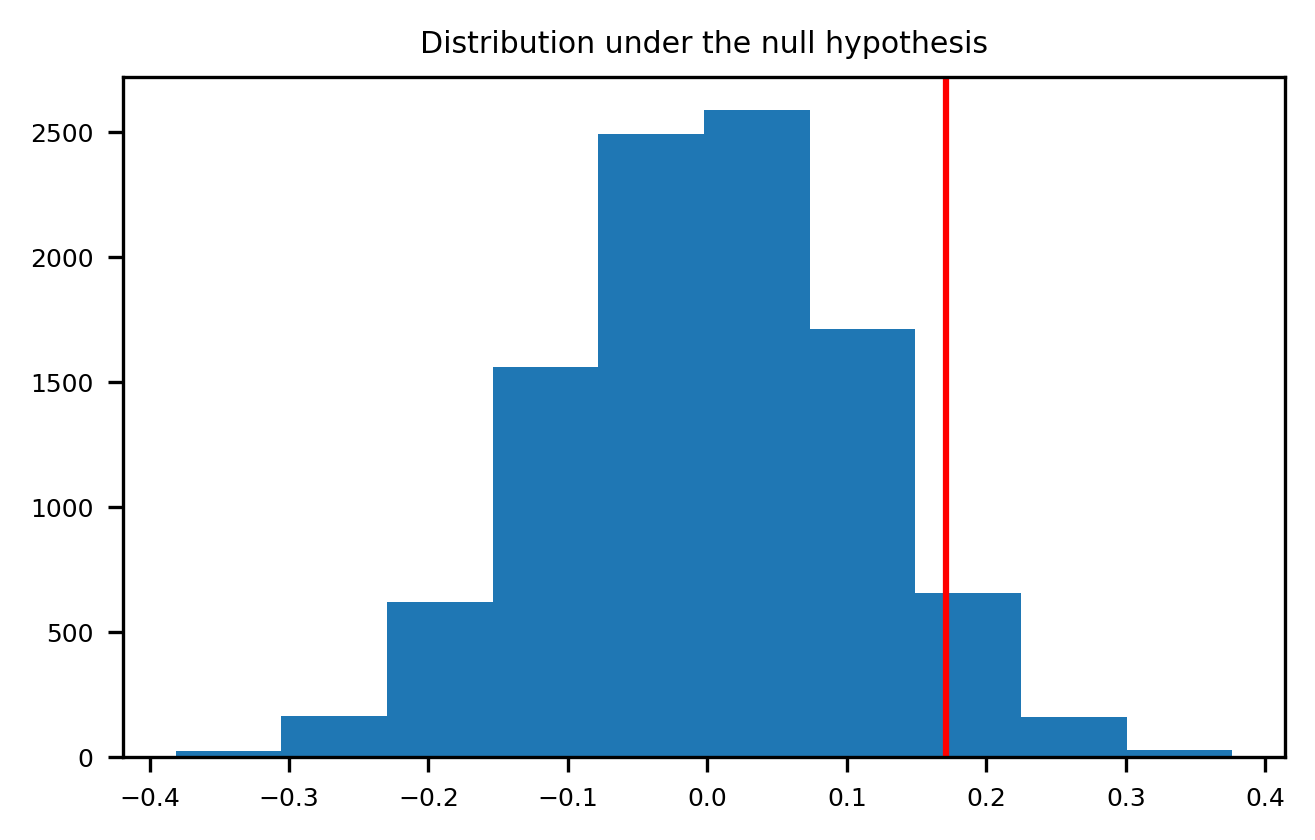

In [68]:
plt.rcParams.update({'font.size': 6})
plt.figure(figsize=(5,3), dpi=300)
# plot null distribution
plt.hist(null_vals);
plt.title("Distribution under the null hypothesis")

# plot line for observed statistic
plt.axvline(x=obs_diff, color = 'red');

In [69]:
# compute p value
(null_vals > obs_diff).mean()

0.057

## Conclusion:
The p-value (0.0499) is slightly higher than alpha=0.05. So it's in the gray area of rejecting/retaining H0. However, the practical significance suggests that we may be ok with 5% error rate in our case and conclude that LinkedIn indeed prefer hiring Postdocs over PhDs, thus rejecting the H0 hypothesis.

## 2.5. POSITION

In [ ]:
def grouped_by_position():
    '''
    Returns Data Frame with aggregated position mentions and their counts
    '''    
    positions = ['Analyst|Analytics','Data Scientist', 'Manager',
                 'Intern|Jr', 'Senior|Sr.', 'Head', 'Lead', 'Director',
                 'Software Engineer|Developer|Programmer', 'Data Engineer', 'Machine Learning Engineer',
                 'Researcher', 'Associate', 'Consultant', 'Strategist']
    positions_num = []

    for each in positions:
        nonans = insight[~insight['position'].isna()]
        positions_nb = nonans['position'][nonans['position'].str.contains(each)].count()
        positions_num.append(positions_nb)
    
    result = list(zip(positions, positions_num))
    
    positions = pd.DataFrame(data=result, columns=['positions', 'positions_num'])
    #positions = positions.sort_values(by='positions_num', ascending=False).reset_index(drop=True)

    return positions

In [ ]:
positions = grouped_by_position()

In [ ]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize=(20,15), dpi=300)
sns.barplot(y = positions.positions, x = positions.positions_num, color=base_color);
plt.title('Job Titles');
plt.xlabel('Number of fellows')
plt.ylabel("")
for i in range(len(positions.positions_num)):
    #X position just after the end of the bar:
    count = positions['positions_num'][i]
    plt.text(count+1, i, count, va = 'center');

## 2.6. PROJECTS by selected companies

Let's have a quick look at the projects by fellows that work at particular company:

In [ ]:
pd.options.display.max_colwidth = 200

In [ ]:
def show_projects_by_company(company):
    print(insight['project'][insight['company'] == company])

In [ ]:
show_projects_by_company('Apple')

In [ ]:
show_projects_by_company('Netflix')

**Summary**: from qualitative review of project titles for two companies, there seems to be no relation between the project and the company. How GitHub relates to Netflix?? I guess the more important thing is that you have your own project, what kind of project is secondary... <br>

But let's have a look at title projects as WordCloud. Maybe it will be more insightful?

## WordCloud of Project Title by Company

In [ ]:
def show_wordcloud_of_projects_by_companies(company):
    subset = insight[insight['company']==company]
    text = " ".join(project for project in subset.project)
    # add stopwords
    stopwords = set(STOPWORDS)
    stopwords.update(["predicting", "data", "Finding", "Predict", "Search", "Find", 'make', 'Finder'])
    
    # plotting wordcloud
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=stopwords).generate(text)
    plt.figure(figsize=[10,10])
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
show_wordcloud_of_projects_by_companies('Netflix')

In [ ]:
show_wordcloud_of_projects_by_companies('Facebook')

## Summary: 
Well, the WordCloud is a little bit more insightful than qualitative analysis. So, those fellows that ended up in Netflix had worked with videos (keywords - Movie, YouTube, TV, CouchTube), while those that got employed at Facebook had projects that deal with text (keywords - Tweet, Twitter) or with marketing (churn, user).

### Most common Words used in Project Titles:

In [ ]:
pd.options.display.max_colwidth = 200

Let's explore the content of the projects that we are interested using keywords:

In [ ]:
def show_projects_using_keyword(keyword):
    print(insight['project'][insight['project'].str.contains(keyword)])

In [ ]:
show_projects_using_keyword('YouTube')

In [ ]:
show_projects_using_keyword('deep learning')

# Conclusion:

This is a brief quick exploratory analysis of the INSIGHT Data Fellows - what background they have, where they come from, what projects they worked on and where they got jobs. One can test lots of hypothesis as the next step.

There are also other insteresting things to do & explore with the INSIGHT Fellowship:
 - The program has also other tracks besides Data Science like AI, Data Eng, Data PM, etc (see https://www.insightdatascience.com/fellows for the full list). like scraping all of the INSIGHT Fellows and check if there are different patterns compared to the DS track. 
 
 
 - Tracing the fellows on LinkedIn and checking how they are doing now - i.e. measuring the impact of the program. Are they still in DS? Do they change companies often? Do they hold senior positions now? etc.
 
 

# References:

INSIGHT Fellowship: https://www.insightdatascience.com/fellows

bradmontgomery/ShortIntroToScraping.rst, https://gist.github.com/bradmontgomery/1872970 (last access: 4/21/2019)


Michael Galarnyk: Python Word Count (Filter out Punctuation, Dictionary Manipulation, and Sorting Lists),
https://codeburst.io/python-basics-11-word-count-filter-out-punctuation-dictionary-manipulation-and-sorting-lists-3f6c55420855 (last access: 4/21/2019)

Duong Vu: Generating WordClouds in Python, https://www.datacamp.com/community/tutorials/wordcloud-python (last access: 4/21/2019)